# Image Captioning using Visual Attention

This project is a project where I explored the use of image captioning for the description of images. As a result I used the tensorflow example that can be found at this link https://www.tensorflow.org/text/tutorials/image_captioning.

This model is inspired by:  Show, Attend and Tell: Neural Image Caption Generation with Visual Attention, but has been updated to use a 2-layer Transformer-decoder.

Throughout this code I comments lines that I may not have fully understand to enable me to understand what is going on in the code and then later apply my code to the use case I want which is to caption images from Flickr30k.

the dataset can be found here:
https://www.kaggle.com/datasets/adityajn105/flickr30k

Due to how large the dataset is I do not load the data in one by one.

But instead I load in the data in chunks and use transfer learning to train on the dataset.

This therefore enables the weights to be updated and easily saved.

<style>
td {
  text-align: center;
}

th {
  text-align: center;
}
</style>

The model architecture built in this tutorial is shown below. Features are extracted from the image, and passed to the cross-attention layers of the Transformer-decoder.

<table>
<tr>
  <th>The model architecture</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://tensorflow.org/images/tutorials/transformer/ImageCaptioning.png"/>
  </td>
</tr>
</table>

The transformer decoder is mainly built from attention layers. It uses self-attention to process the sequence being generated, and it uses cross-attention to attend to the image.

By inspecting the attention weights of the cross attention layers you will see what parts of the image the model is looking at as it generates words.

![Prediction](https://tensorflow.org/images/imcap_prediction.png)

This notebook is an end-to-end example. When you run the notebook, it downloads a dataset, extracts and caches the image features, and trains a decoder model. It then uses the model to generate captions on new images.

## Setup

In [ ]:
!pip install gradio

In [ ]:
# This command is used to install a specific version of the cuDNN library on a system (or environment) that uses the APT package manager,
# typically found on Debian-based Linux distributions such as Ubuntu.
!apt install --allow-change-held-packages libcudnn8=8.6.0.163-1+cuda11.8

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8
0 upgraded, 0 newly installed, 1 downgraded, 1 to remove and 14 not upgraded.
Need to get 446 MB of archives.
After this operation, 1,315 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  libcudnn8 8.6.0.163-1+cuda11.8 [446 MB]
Fetched 446 MB in 5s (97.8 MB/s)
(Reading database ... 120831 files and directories currently installed.)
Removing libcudnn8-dev (8.9.0.131-1+cuda11.8) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
dpkg: warning: downgrading libcudnn8 from 8.9.0.131-1+cuda11.8 to 8.6.0.163-1+cuda11.8
(Reading database ... 120798 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.

In [ ]:
!pip uninstall -y tensorflow estimator keras

Found existing installation: tensorflow 2.12.0
Uninstalling tensorflow-2.12.0:
  Successfully uninstalled tensorflow-2.12.0
Found existing installation: keras 2.12.0
Uninstalling keras-2.12.0:
  Successfully uninstalled keras-2.12.0


In [ ]:
!pip install -U tensorflow_text tensorflow tensorflow_datasets
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 64.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 87.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 43.0 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.3
    Uninstalling tensorboard-2.12.3:
      Successfully uninstalled tensorboard-2.12.3
ERROR: pip's depend

In [ ]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.1 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade tensorflow
!pip install --upgrade keras


This tutorial uses lots of imports, mostly for loading the dataset(s).

In [ ]:
#@title
import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request
# from datasets import load_dataset
import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
import tqdm

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds

from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO
# if after installing gradio
import gradio as gr

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Prepare Datasets

### Remove corrupted images use only if needed

In [ ]:
# import os
# from PIL import Image

# def is_image_corrupted(image_path):
#     try:
#         img = Image.open(image_path)
#         img.verify()  # This will raise an exception if the image is corrupted
#         return False  # Image is not corrupted
#     except Exception as e:
#         print(f"Corrupted image: {image_path} - {e}")
#         return True  # Image is corrupted

# def remove_corrupted_images(folder_path):
#     for filename in os.listdir(folder_path):
#         image_path = os.path.join(folder_path, filename)
#         if is_image_corrupted(image_path):
#             os.remove(image_path)
#             print(f"Removed corrupted image: {image_path}")

# folder_path = "/content/drive/MyDrive/Projects/DeepLearning/Datasets/Memes/InterpretMemes/training"
# remove_corrupted_images(folder_path)


In [ ]:
# import os

# supported_formats = ['.jpeg', '.jpg', '.png', '.gif', '.bmp']
# directory = '/content/drive/MyDrive/Projects/DeepLearning/Datasets/Memes/InterpretMemes/training'

# unsupported_images = []

# for filename in os.listdir(directory):
#     if os.path.splitext(filename)[1].lower() not in supported_formats:
#         unsupported_images.append(filename)

# print("Unsupported Images:", unsupported_images)


In [ ]:
# from PIL import Image

# directory = '/content/drive/MyDrive/Projects/DeepLearning/Datasets/Memes/InterpretMemes/training'

# for filename in os.listdir(directory):
#     if os.path.splitext(filename)[1].lower() == '.png':
#         image_path = os.path.join(directory, filename)
#         try:
#             img = Image.open(image_path)
#             img = img.convert('RGB')  # Convert to RGB to fix profile issues
#             img.save(image_path)
#             print(f"Corrected sRGB profile for {filename}")
#         except Exception as e:
#             print(f"Error fixing sRGB profile for {filename}: {e}")


### Load hugging face dataset on guns

In [ ]:
dataset = load_dataset("red_caps", split="train")

Generating train split:   0%|          | 0/12011121 [00:00<?, ? examples/s]

In [ ]:
df = dataset.to_pandas()

# List of columns to drop
columns_to_drop = ['image_id', 'author', 'raw_caption', 'subreddit', 'score', 'created_utc', 'permalink', 'crosspost_parents']

# Drop the specified columns
limited_dataset = df.drop(columns=columns_to_drop)

# # Convert the modified DataFrame back to a Hugging Face dataset split
# modified_dataset = dataset['split_name'].from_pandas(df_dropped)
limited_dataset

,image_url,caption
0,http://i.imgur.com/VBg9K.jpg,ussr time abandoned appliances in some factory
1,http://i.imgur.com/s5KYB.jpg,"abandoned alley in porto, portugal"
2,http://i.imgur.com/X9zmL.jpg,mig 21 at an abandoned russian military base
3,http://i.imgur.com/EIg0f.jpg,me standing in front of one of many hangars in...
4,http://i.imgur.com/hwzwc.jpg,"abandoned brdm-2 in pripyat, ukraine"
...,...,...
12011116,https://i.imgur.com/WTscWjw.jpg,turn your used bottles into drinking glasses!
12011117,https://i.redd.it/g26w77rldi861.jpg,replacement lens help
12011118,https://i.redd.it/gmykw7sknj861.jpg,"my house is poorly insulated, and it's somethi..."
12011119,https://i.redd.it/dnzs8ctfbk861.jpg,reuse maple syrup bottle for vainilla.


In [ ]:
import pandas as pd

# Assuming you have your DataFrame named 'limited_dataset'
keyword = " gun "
filtered_rows = limited_dataset[limited_dataset["caption"].str.lower().str.contains(keyword)]
limited_filtered_rows = filtered_rows.head(8000)
# Assuming you have your DataFrame named 'limited_filtered_rows'
data_list = [(row["image_url"], row["caption"]) for _, row in limited_filtered_rows.iterrows()]






In [ ]:
descriptions = dict(data_list)
descriptions

{'http://i.imgur.com/KkTSR.jpg': 'abandoned gun turrets on bribie island beach, queensland, australia. . mic...',
 'http://i.imgur.com/vxARL.jpg': 'i was told at /r/guns that i should maybe post this here. it is an old naval gun at the finnish sea fortress.',
 'http://i.imgur.com/aGBSPDD.jpg': 'view from the gun port of a german bunker, normady, france',
 'http://farm1.staticflickr.com/246/524783430_7ec295a470_z.jpg': 'a wwii japanese machine gun resist time',
 'http://i.imgur.com/64ztcsY.jpg': "wwii-era gun guarding st. john's harbour, nl",
 'http://i.imgur.com/Dp4goxn.jpg': 'the house from top gun in oceanside, ca',
 'http://i.imgur.com/u7M3eXN.jpg': 'old gun emplacement, georges heights, sydney',
 'http://i.imgur.com/sfFA16u.jpg': 'winchester gun factory, new haven, ct',
 'http://i.imgur.com/ATHenlt.jpg': "abandoned ww2 gun on cahill point in st.john's, newfoundland",
 'http://i.imgur.com/JFX8C12.jpg': 'this sherman m4 tank was stranded on the reef during the invasion of the island 

### Load Flickr30k dataset






In [ ]:
import pandas as pd

# used to read CSV file to match images and captions
def img_capt(filename):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(filename, sep='|', header=None)

    # Process each row in the DataFrame to build the descriptions dictionary
    descriptions = {}
    for index, row in df.iterrows():
        img_name =  "/content/drive/MyDrive/Projects/DeepLearning/Datasets/Flickr30k/flickr30k_images/" + row[0].strip()


        # Check if the value is a string, otherwise convert it to an empty string
        caption_parts = [str(part).strip() for part in row[1:]]

        # Combine all caption parts to form the final caption for the image
        caption = ' '.join(caption_parts)

        if img_name not in descriptions:
            descriptions[img_name] = [caption]
        else:
            descriptions[img_name].append(caption)

    return descriptions




#Data cleaning function will convert all upper case alphabets to lowercase, removing punctuations and words containing numbers
def txt_clean(captions):
  table = str.maketrans('', '', string.punctuation)
  for img, caps in captions.items():
      for i, img_caption in enumerate(caps):
          img_caption.replace("-", " ")
          descp = img_caption.split()
          images_to_skip = set()
          # Uppercase to lowercase
          descp = [wrd.lower() for wrd in descp]
          # Remove punctuation from each token
          descp = [wrd.translate(table) for wrd in descp]
          # Remove hanging 's and a
          descp = [wrd for wrd in descp if(len(wrd) > 1)]
          # Remove words containing numbers
          descp = [wrd for wrd in descp if(wrd.isalpha())]
          # Converting back to string
          img_caption = ' '.join(descp)
          # Add start and end tags to the description
          img_caption = '[START]' + img_caption + '[END]'
          captions[img][i] = img_caption
  return captions

# Get vocab
def txt_vocab(descriptions):
    # To build vocab of all unique words
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab

#To save all descriptions in one file
def save_descriptions(descriptions, filename):
  lines = list()
  for key, desc_list in descriptions.items():
    for desc in desc_list:
              lines.append(key + 't' + desc )
  data = "n".join(lines)
  file = open(filename,"w")
  file.write(data)
  file.close()

# Set these path according to project folder in you system, like i create a folder with my name shikha inside D-drive
dataset_text = "/content/drive/MyDrive/Projects/DeepLearning/Datasets/flickr30k_images/results.csv"
dataset_images = "/content/drive/MyDrive/Projects/DeepLearning/Datasets/Flickr30k/flickr30k_images"



# To prepare our text data
filename = dataset_text   # Replace 'your_csv_file.csv' with the actual CSV filename.

# Loading the file that contains all data
# Map them into descriptions dictionary
descriptions = img_capt(filename)

# Remove the first key because the first key contains the headings of the CSV file.
if descriptions:
    first_key, first_value = next(iter(descriptions.items()))
    del descriptions[first_key]
    print("Removed key using dictionary unpacking:", first_key)
    print("Removed value using dictionary unpacking:", first_value)
else:
    print("The dictionary is empty.")


# Cleaning the descriptions
clean_descriptions = txt_clean(descriptions)

# To build vocabulary
vocabulary = txt_vocab(clean_descriptions)
print("Length of vocabulary =", len(vocabulary))

# Saving all descriptions in one file
save_descriptions(clean_descriptions, "/content/drive/MyDrive/Projects/DeepLearning/Datasets/flickr30k_images/descriptions.txt")


In [ ]:
clean_descriptions

### Load in Memes dataset

In [ ]:

import pandas as pd

import json

def img_capt(filename):
    descriptions = {}
    with open(filename, 'r') as file:
        data_list = json.load(file)  # Load the entire JSON list
        for data in data_list:
            img_name = os.path.basename(str(data['img_fname']))
            img_path = "/content/drive/MyDrive/Projects/DeepLearning/Datasets/Memes/InterpretMemes/training/" + img_name
            descriptions[img_path] = data['captions']
    return descriptions





#Data cleaning function will convert all upper case alphabets to lowercase, removing punctuations and words containing numbers
def txt_clean(captions):
    table = str.maketrans('', '', string.punctuation)
    for img, caps in captions.items():
        last_caption = caps[-1]  # Take the last caption from the list
        descp = last_caption.split()

        # Uppercase to lowercase
        descp = [wrd.lower() for wrd in descp]
        # Remove punctuation from each token
        descp = [wrd.translate(table) for wrd in descp]
        # Remove hanging 's and a
        descp = [wrd for wrd in descp if(len(wrd) > 1)]
        # Remove words containing numbers
        descp = [wrd for wrd in descp if(wrd.isalpha())]
        # Converting back to string
        img_caption = ' '.join(descp)
        # Add start and end tags to the description
        img_caption = '[START]' + img_caption + '[END]'
        captions[img] = [img_caption]  # Update the captions list with the cleaned last caption
    return captions

def txt_vocab(descriptions):
    # To build vocab of all unique words
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab
#To save all descriptions in one file
# Modify the save_descriptions function to format the data as desired
def save_descriptions(descriptions, filename):
    lines = []
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc)  # Use '\t' to separate image path and caption
    data = "\n".join(lines)  # Use '\n' to separate each image-caption pair
    with open(filename, "w") as file:
        file.write(data)

# Save descriptions in the desired format

# Set these path according to project folder in you system, like i create a folder with my name shikha inside D-drive
dataset_text = "/content/drive/MyDrive/Projects/DeepLearning/Datasets/Memes/InterpretMemes/imagesAndCaptions.json"
dataset_images = "/content/drive/MyDrive/Projects/DeepLearning/Datasets/Memes/InterpretMemes/training"
#to prepare our text data
# ...

# To prepare our text data
filename = dataset_text   # Replace 'your_csv_file.csv' with the actual CSV filename.
# Loading the file that contains all data
# Map them into descriptions dictionary
descriptions = img_capt(filename)
# if descriptions:
#     first_key, first_value = next(iter(descriptions.items()))
#     del descriptions[first_key]
#     print("Removed key using dictionary unpacking:", first_key)
#     print("Removed value using dictionary unpacking:", first_value)
# else:
#     print("The dictionary is empty.")


# Cleaning the descriptions
clean_descriptions = txt_clean(descriptions)

# To build vocabulary
vocabulary = txt_vocab(clean_descriptions)
print("Length of vocabulary =", len(vocabulary))

# Saving all descriptions in one file
save_descriptions(clean_descriptions, "/content/drive/MyDrive/Projects/DeepLearning/Datasets/Memes/InterpretMemes/descriptions.txt")


Length of vocabulary = 7573


In [ ]:
len(descriptions)

31783

### Get ready to turn into a tf dataset

In [ ]:
clean_descriptions

In [ ]:
train_captions = [(filename, captions) for filename, captions in clean_descriptions.items()]


In [ ]:
train_captions

In [ ]:
import tensorflow as tf

# # Assuming train_raw is a tf.data.Dataset object
# train_raw = tf.data.experimental.from_list(train_captions)

# # # Save the train_raw dataset to disk in TFRecord format
save_path = '/content/drive/MyDrive/Projects/DeepLearning/Ofcom/30k/train_raw.tfrecord'
# tf.data.experimental.save(train_raw, save_path)

# # Load the dataset back from the saved file
train_raw = tf.data.experimental.load(save_path)

# Verify that the loaded_dataset matches the original train_raw
for data in train_raw.take(1):
    print(data)





Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.


(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Projects/DeepLearning/Datasets/Flickr30k/flickr30k_images/1000092795.jpg'>, <tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'[START]two young guys with shaggy hair look at their hands while hanging out in the yard[END]',
       b'[START]two young white males are outside near many bushes[END]',
       b'[START]two men in green shirts are standing in yard[END]',
       b'[START]man in blue shirt standing in garden[END]',
       b'[START]two friends enjoy time spent together[END]'], dtype=object)>)


In [ ]:
train_raw

<_LoadDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.string, name=None))>

In [ ]:
for ex_path, ex_captions in train_raw.take(1):
  print(ex_path)
  print(ex_captions)

tf.Tensor(b'/content/drive/MyDrive/Projects/DeepLearning/Datasets/Flickr30k/flickr30k_images/1000092795.jpg', shape=(), dtype=string)
tf.Tensor(
[b'[START]two young guys with shaggy hair look at their hands while hanging out in the yard[END]'
 b'[START]two young white males are outside near many bushes[END]'
 b'[START]two men in green shirts are standing in yard[END]'
 b'[START]man in blue shirt standing in garden[END]'
 b'[START]two friends enjoy time spent together[END]'], shape=(5,), dtype=string)


### Image feature extractor

I will use an image model (pretrained on imagenet) to extract the features from each image. The model was trained as an image classifier, but setting `include_top=False` returns the model without the final classification layer, so you can use the last layer of feature-maps:  


In [ ]:
IMAGE_SHAPE=(224, 224, 3)
mobilenet = tf.keras.applications.MobileNetV3Small(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    include_preprocessing=True)
mobilenet.trainable=False

4334752/4334752 [==============================] - 1s 0us/step


Here's a function to load an image and resize it for the model:

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

The model returns a feature map for each image in the input batch:

In [ ]:
test_img_batch = load_image(ex_path)[tf.newaxis, :]

print(test_img_batch.shape)
print(mobilenet(test_img_batch).shape)

(1, 224, 224, 3)
(1, 7, 7, 576)


### Setup the text tokenizer/vectorizer

I will transform the text captions into integer sequences using the [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer, with the following steps:

* Use [adapt](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization#adapt) to iterate over all captions, split the captions into words, and compute a vocabulary of the top words.
* Tokenize all captions by mapping each word to its index in the vocabulary. All output sequences will be padded to length 50.
* Create word-to-index and index-to-word mappings to display results.

In [ ]:
def standardize(s):
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

In [ ]:
# Use the top 7000 words to get a much larger vocabulary
vocabulary_size = 7000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True)
# Learn the vocabulary from the caption data.

In [ ]:
tokenizer.adapt(train_raw.map(lambda fp,txt: txt).unbatch().batch(1024))

In [ ]:
tokenizer.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', 'in', 'the', 'on', 'and', 'is', 'of']

In [ ]:
t = tokenizer([['a cat in a hat'], ['a robot dog']])
t

<tf.RaggedTensor [[2, 1, 1125, 4, 1, 62, 3], [2, 1, 5782, 39, 3]]>

In [ ]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [ ]:
w = index_to_word(t)
w.to_list()

[[b'[START]', b'[UNK]', b'cat', b'in', b'[UNK]', b'hat', b'[END]'],
 [b'[START]', b'[UNK]', b'robot', b'dog', b'[END]']]

In [ ]:
tf.strings.reduce_join(w, separator=' ', axis=-1).numpy()

array([b'[START] [UNK] cat in [UNK] hat [END]',
       b'[START] [UNK] robot dog [END]'], dtype=object)

### Prepare the datasets

The `train_raw` dataset contains 1:many `(image, captions)` pairs.

This function will replicate the image so there are 1:1 images to captions:

In [ ]:
def match_shapes(images, captions):
  caption_shape = einops.parse_shape(captions, 'b c')
  captions = einops.rearrange(captions, 'b c -> (b c)')
  images = einops.repeat(
      images, 'b ... -> (b c) ...',
      c = caption_shape['c'])
  return images, captions

In [ ]:
for ex_paths, ex_captions in train_raw.batch(32).take(1):
  break

print('image paths:', ex_paths.shape)
print('captions:', ex_captions.shape)
print()

ex_paths, ex_captions = match_shapes(images=ex_paths, captions=ex_captions)

print('image_paths:', ex_paths.shape)
print('captions:', ex_captions.shape)


To be compatible with keras training the dataset should contain `(inputs, labels)` pairs. For text generation the tokens are both an input and the labels, shifted by one step. This function will convert an `(images, texts)` pair to an `((images, input_tokens), label_tokens)` pair:

In [ ]:
def prepare_txt(imgs, txts):
  tokens = tokenizer(txts)

  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  return (imgs, input_tokens), label_tokens

This function adds operations to a dataset. The steps are:

1. Load the images (and ignore images that fail to load).
2. Replicate images to match the number of captions.
3. Shuffle and rebatch the `image, caption` pairs.
4. Tokenize the text, shift the tokens and add `label_tokens`.
5. Convert the text from a `RaggedTensor` representation to padded dense `Tensor` representation.

In [ ]:
def prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
  # Load the images and make batches.
  ds = (ds
        .shuffle(10000)
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), out_tok.to_tensor()

  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )

You could install the feature extractor in your model and train on the datasets like this:

In [ ]:
train_ds = prepare_dataset(train_raw, tokenizer)
train_ds.element_spec

In [ ]:
# test_ds = prepare_dataset(test_raw, tokenizer)
# test_ds.element_spec

### [Optional] Cache the image features

Since the image feature extractor is not changing, and this tutorial is not using image augmentation, the image features can be cached. Same for the text tokenization. The time it takes to set up the cache is earned back on each epoch during training and validation. The code below defines two functions `save_dataset` and `load_dataset`:



Had to modify to make faster

In [ ]:
def save_dataset(ds, save_path, image_model, tokenizer, shards=10, batch_size=32):
    # Load the images and make batches in parallel
    ds = (ds
          .map(lambda path, caption: (load_image(path), caption), num_parallel_calls=tf.data.AUTOTUNE)
          .batch(batch_size)
          .cache()  # Cache the preprocessed images in memory
          .prefetch(tf.data.AUTOTUNE))  # Prefetch batches for faster processing

    # Run the feature extractor on each batch in parallel
    def gen():
        for (images, captions) in tqdm.tqdm(ds):
            feature_maps = image_model(images)

            feature_maps, captions = match_shapes(feature_maps, captions)
            yield feature_maps, captions

    # Wrap the generator in a new tf.data.Dataset.
    new_ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=image_model.output_shape),
            tf.TensorSpec(shape=(None,), dtype=tf.string)))

    # Apply the tokenization and save the dataset into shard files.
    def shard_func(i, item):
        return i % shards

    new_ds = (new_ds
              .map(prepare_txt, num_parallel_calls=tf.data.AUTOTUNE)  # Tokenization in parallel
              .unbatch()
              .shuffle(1000))

    new_ds.enumerate().save(save_path, shard_func=shard_func)


Had to take the dataset bit by bit as loading in the entire dataset was too much for the kernel on colab to handle

In [ ]:
# Load the dataset back from the saved file
train_raw = tf.data.experimental.load('/content/drive/MyDrive/Projects/DeepLearning/Ofcom/30k/train_raw.tfrecord')
train_raw_subset = train_raw.skip(24000).take(8000)
save_dataset(train_raw_subset, '/content/drive/MyDrive/Projects/DeepLearning/Ofcom/30k/caches/24k-ENDktrain_cache', mobilenet, tokenizer)


                                                  #Debug if save_dataset is not working well
# import logging

# # Configure logging
# logging.basicConfig(filename='/content/drive/MyDrive/debug.log', level=logging.DEBUG)

# try:
#     # Load the dataset back from the saved file
#     train_raw = tf.data.experimental.load('/content/drive/MyDrive/Projects/DeepLearning/Datasets/Memes/InterpretMemes/train_raw.tfrecord')
#     # train_raw_subset = train_raw.skip(8000).take(8000)

#     # Print a debug message
#     logging.debug("Loaded dataset successfully")

#     # Save the dataset
#     save_dataset(train_raw, '/content/drive/MyDrive/Projects/DeepLearning/Datasets/Memes/InterpretMemes/cache/dataCache', mobilenet, tokenizer)

#     # Print a debug message
#     logging.debug("Dataset saved successfully")

# except Exception as e:
#     # Print the exception details
#     logging.error(f"An error occurred: {e}")



 </section>


## Data ready for training

After those preprocessing steps, here are the datasets:

In [ ]:
def load_dataset(save_path, batch_size=32, shuffle=1000, cycle_length=2):
  def custom_reader_func(datasets):
    datasets = datasets.shuffle(1000)
    return datasets.interleave(lambda x: x, cycle_length=cycle_length)

  ds = tf.data.Dataset.load(save_path, reader_func=custom_reader_func)

  def drop_index(i, x):
    return x

  ds = (ds
        .map(drop_index, tf.data.AUTOTUNE)
        .shuffle(shuffle)
        .padded_batch(batch_size)
        .prefetch(tf.data.AUTOTUNE))
  return ds

In [ ]:
train_ds = load_dataset('/content/drive/MyDrive/Projects/DeepLearning/Ofcom/30k/caches/24k-ENDktrain_cache')
# test_ds = load_dataset('test_cache')

In [ ]:
train_ds

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 7, 7, 576), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None)), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

The dataset now returns `(input, label)` pairs suitable for training with keras. The `inputs` are `(images, input_tokens)` pairs. The `images` have been processed with the feature-extractor model. For each location in the `input_tokens` the model looks at the text so far and tries to predict the next which is lined up at the same location in the `labels`.

In [ ]:
for (inputs, ex_labels) in train_ds.take(1):
  (ex_img, ex_in_tok) = inputs

print(ex_img.shape)
print(ex_in_tok.shape)
print(ex_labels.shape)

(32, 7, 7, 576)
(32, 21)
(32, 21)


The input tokens and the labels are the same, just shifted by 1 step:

In [ ]:
print(ex_in_tok[0].numpy())
print(ex_labels[0].numpy())

[  2  54 120  12  47  57 194 417   0   0   0   0   0   0   0   0   0   0
   0   0   0]
[ 54 120  12  47  57 194 417   3   0   0   0   0   0   0   0   0   0   0
   0   0   0]


## A Transformer decoder model

This model assumes that the pretrained image encoder is sufficient, and just focuses on building the text decoder. This tutorial uses a 2-layer Transformer-decoder.

The implementations are almost identical to those in the [Transformers tutorial](https://www.tensorflow.org/text/tutorials/transformer). Refer back to it for more details.

<table>
<tr>
  <th>The Transformer encoder and decoder.</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

The model will be implemented in three main parts:

1. Input - The token embedding and positional encoding (`SeqEmbedding`).
1. Decoder - A stack of transformer decoder layers (`DecoderLayer`) where each contains:
   1. A causal self attention later (`CausalSelfAttention`), where each output location can attend to the output so far.
   1. A cross attention layer (`CrossAttention`) where each output location can attend to the input image.
   1. A feed forward network (`FeedForward`) layer which further processes each output location independently.
1. Output - A multiclass-classification over the output vocabulary.


### Input

The input text has already been split up into tokens and converted to sequences of IDs.

Remember that unlike a CNN or RNN the Transformer's attention layers are invariant to the order of the sequence. Without some positional input, it just sees an unordered set not a sequence. So in addition to a simple vector embedding for each token ID, the embedding layer will also include an embedding for each position in the sequence.

The `SeqEmbedding` layer defined below:

- It looks up the embedding vector for each token.
- It looks up an embedding vector for each sequence location.
- It adds the two together.
- It uses `mask_zero=True` to initialize the keras-masks for the model.

Note: This implementation learns the position embeddings instead of using fixed embeddings like in the [Transformer tutorial](https://www.tensorflow.org/text/tutorials/transformer). Learning the embeddings is slightly less code, but doesn't generalize to longer sequences.

In [ ]:
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

    self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=depth,
        mask_zero=True)

    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq,x])

### Decoder

The decoder is a standard Transformer-decoder, it contains a stack of `DecoderLayers` where each contains three sublayers: a `CausalSelfAttention`, a `CrossAttention`, and a`FeedForward`. The implementations are almost identical to the [Transformer tutorial](https://www.tensorflow.org/text/tutorials/transformer), refer to it for more details.

The `CausalSelfAttention` layer is below:

In [ ]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add()
    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)


The `CrossAttention` layer is below. Note the use of `return_attention_scores`.

In [ ]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add()
    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)

    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

The `FeedForward` layer is below. Remember that a `layers.Dense` layer is applied to the last axis of the input. The input will have a shape of `(batch, sequence, channels)`, so it automatically applies pointwise across the `batch` and `sequence` axes.  

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)


Next arrange these three layers into a larger `DecoderLayer`. Each decoder layer applies the three smaller layers in sequence. After each sublayer the shape of `out_seq` is `(batch, sequence, channels)`. The decoder layer also returns the `attention_scores` for later visualizations.

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()

    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)


  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)

    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)

    return out_seq

### Output

At minimum the output layer needs a `layers.Dense` layer to generate logit-predictions for each token at each location.

But there are a few other features you can add to make this work a little better:

1. **Handle bad tokens**: The model will be generating text. It should
   never generate a pad, unknown, or start token (`''`, `'[UNK]'`,
   `'[START]'`). So set the bias for these to a large negative value.

   > Note: You'll need to ignore these tokens in the loss function as well.

2. **Smart initialization**: The default initialization of a dense layer will
  give a model that initially predicts each token with almost uniform
  likelihood. The actual token distribution is far from uniform. The
  optimal value for the initial bias of the output layer is the log of the
  probability of each token. So include an `adapt` method to count the tokens
  and set the optimal initial bias. This reduces the initial loss from the
  entropy of the uniform distribution (`log(vocabulary_size)`) to the marginal
  entropy of the distribution (`-p*log(p)`).


In [ ]:
#@title
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()

    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm.tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    # TODO(b/250038731): Fix this.
    # An Add layer doesn't work because of the different shapes.
    # This clears the mask, that's okay because it prevents keras from rescaling
    # the losses.
    return x + self.bias


The smart initialization will significantly reduce the initial loss:

In [ ]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]',))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

100%|██████████| 1217/1217 [00:29<00:00, 41.46it/s]


Uniform entropy: 8.85
Marginal entropy: 6.15


### Build the model

To build the model, you need to combine several parts:

1. The image `feature_extractor` and the text `tokenizer` and.
1. The `seq_embedding` layer, to convert batches of token-IDs to
   vectors `(batch, sequence, channels)`.
3. The stack of `DecoderLayers` layers that will process the text and image data.
4. The `output_layer` which returns a pointwise prediction of what the next word should be.

In [ ]:
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=50, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True)

    self.seq_embedding = SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units,
        max_length=max_length)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer

When you call the model, for training, it receives an `image, txt` pair. To make this function more usable, be flexible about the input:

* If the image has 3 channels run it through the feature_extractor. Otherwise assume that it has been already. Similarly
* If the text has dtype `tf.string` run it through the tokenizer.

After that running the model is only a few steps:

1. Flatten the extracted image features, so they can be input to the decoder layers.
2. Look up the token embeddings.
3. Run the stack of `DecoderLayer`s, on the image features and text embeddings.
4. Run the output layer to predict the next token at each position.


In [ ]:
@Captioner.add_method
def call(self, inputs):
  image, txt = inputs

  if image.shape[-1] == 3:
    # Apply the feature-extractor, if you get an RGB image.
    image = self.feature_extractor(image)

  # Flatten the feature map
  image = einops.rearrange(image, 'b h w c -> b (h w) c')


  if txt.dtype == tf.string:
    # Apply the tokenizer if you get string inputs.
    txt = tokenizer(txt)

  txt = self.seq_embedding(txt)

  # Look at the image
  for dec_layer in self.decoder_layers:
    txt = dec_layer(inputs=(image, txt))

  txt = self.output_layer(txt)

  return txt

In [ ]:
model = Captioner(tokenizer, feature_extractor=mobilenet, output_layer=output_layer,
                  units=256, dropout_rate=0.5, num_layers=3, num_heads=15)
# 20 heads, 3 layers
# model.summary()


### Generate captions

Before getting into training, write a bit of code to generate captions. You'll use this to see how training is progressing.

Start by downloading a test image:

In [ ]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
image = load_image(image_path)

64400/64400 [==============================] - 0s 5us/step


To caption an image with this model:

- Extract the `img_features`
- Initialize the list of output tokens with a `[START]` token.
- Pass `img_features` and `tokens` into the model.
  - It returns a list of logits.
  - Choose the next token based on those logits.  
  - Add it to the list of tokens, and continue the loop.
  - If it generates an `'[END]'` token, break out of the loop.

So add a "simple" method to do just that:

In [ ]:
@Captioner.add_method
def simple_gen(self, image, temperature=1):
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  img_features = self.feature_extractor(image[tf.newaxis, ...])

  tokens = initial # (batch, sequence)
  for n in range(50):
    preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
    preds = preds[:,-1, :]  #(batch, vocab)
    if temperature==0:
        next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
    else:
        next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
    tokens = tf.concat([tokens, next], axis=1) # (batch, sequence)

    if next[0] == self.word_to_index('[END]'):
      break
  words = index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

Here are some generated captions for that image, the model's untrained, so they don't make much sense yet:

In [ ]:
for t in (0.0, 0.5, 1.0):
  result = model.simple_gen(image, temperature=t)
  print(result)



about jacket and naked piercings in riding cutting startgroup aqua stand number behind


The temperature parameter allows you to interpolate between 3 modes:

1. Greedy decoding (`temperature=0.0`) - Chooses the most likely next token at each step.
2. Random sampling according to the logits (`temperature=1.0`).
3. Uniform random sampling (`temperature >> 1.0`).

Since the model is untrained, and it used the frequency-based initialization, the "greedy" output (first) usually only contains the most common tokens: `['a', '.', '[END]']`.

## Train

To train the model you'll need several additional components:

- The Loss and metrics
- The Optimizer
- Optional Callbacks

### Losses and metrics

Here's an implementation of a masked loss and accuracy:

When calculating the mask for the loss, note the `loss < 1e8`. This term discards the artificial, impossibly high losses for the `banned_tokens`.

In [ ]:
def masked_loss(labels, preds):
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8)
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

### Callbacks

For feedback during training setup a `keras.callbacks.Callback` to generate some captions for the surfer image at the end of each epoch.

In [ ]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    image_url = 'https://tensorflow.org/images/surf.jpg'
    image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
    self.image = load_image(image_path)

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    for t in (0.0, 0.5, 1.0):
      result = self.model.simple_gen(self.image, temperature=t)
      print(result)
    print()


It generates three output strings, like the earlier example, like before the first is "greedy", choosing the argmax of the logits at each step.

In [ ]:
g = GenerateText()
g.model = model
g.on_epoch_end(0)




with his starttwo in
lab yellow eventend and down sitting with startbaby in hit in are



Also use `callbacks.EarlyStopping` to terminate training when the model starts to overfit.

In [ ]:
callbacks = [
    GenerateText(),
    tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True)]

In [ ]:
# model.build(input_shape)

In [ ]:
# # # All layers in our model can now be trained
# for layer in model.layers[:-1]:
#   layer.trainable=False

# # training output
# model.layers[0].trainable=True
# model.layers[-1].trainable=True



model.load_weights("/content/drive/MyDrive/Projects/DeepLearning/Ofcom/DemoDay/weights/4)/model_weights")

In [ ]:
# print(model.layers[0].name)

MobilenetV3small


In [ ]:
# for layer in model.layers:
#     try:
#         print(layer.name, layer.input_shape, layer.output_shape)
#     except AttributeError:
#         print(f'{layer.name} has no defined input or output shape')


MobilenetV3small (None, 224, 224, 3) (None, 7, 7, 576)
text_vectorization_1 has no defined input or output shape
string_lookup_8 has no defined input or output shape
string_lookup_9 has no defined input or output shape
seq_embedding_1 has no defined input or output shape
decoder_layer_3 has no defined input or output shape
decoder_layer_4 has no defined input or output shape
decoder_layer_5 has no defined input or output shape
token_output_1 has no defined input or output shape


### Train

In [ ]:
!pip install tensorflow

Configure and execute the training.

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

For more frequent reporting, use the `Dataset.repeat()` method, and set the `steps_per_epoch` and `validation_steps` arguments to `Model.fit`.

With this setup on `Flickr8k` a full pass over the dataset is 900+ batches, but below the reporting-epochs are 100 steps.

In [ ]:
history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)


Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 3.6541 - masked_acc: 0.2975

startman in red cap and white shirt is riding wave in the oceanend
startman in white shirt is riding waveend


startsurfer riding waveend

100/100 [==============================] - 81s 227ms/step - loss: 3.6541 - masked_acc: 0.2975
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 3.6684 - masked_acc: 0.2983

startsurfer riding wave in the ocean with his arms in the air and his handend
startsurfer in black and white wetsuit is riding waveend


startsurfer dressed in red surfs with large bubble waveend

100/100 [==============================] - 17s 172ms/step - loss: 3.6684 - masked_acc: 0.2983
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 3.5213 - masked_acc: 0.3069

startman in red wetsuit is surfing in the ocean with surfboardend
startsurfer rides wave in the oceanend


startman in wetsuit rides wavesend

100/100 [==============================] - 14s 138ms/step - loss: 3.5213 - masked_acc: 0.3069
Epoch 4/100
100/100 [==============================] - ETA: 0s - loss: 3.5010 - masked_acc: 0.3131

startman in red and white wetsuit rides waveend
startman surfing in the oceanend


startsurfer on wave too the is on waveend

100/100 [==============================] - 13s 126ms/step - loss: 3.5010 - masked_acc: 0.3131
Epoch 5/100
100/100 [==============================] - ETA: 0s - loss: 3.4968 - masked_acc: 0.3101

startman in red cap is surfing in the oceanend
startman in black wetsuit surfing in the oceanend


startsurfer riding wave in the waterend

100/100 [==============================] - 13s 126ms/step - loss: 3.4968 - masked_acc: 0.3101
Epoch 6/100
100/100 [==============================] - ETA: 0s - loss: 3.4242 - masked_acc: 0.3210

startsurfer in red and white wetsuit is riding waveend
startsurfer is surfing in the ocean of waveend


startan african gentleman on jet ski paddle was doing midair with his hands in the airend

100/100 [==============================] - 13s 133ms/step - loss: 3.4242 - masked_acc: 0.3210
Epoch 7/100
100/100 [==============================] - ETA: 0s - loss: 3.4666 - masked_acc: 0.3117

startsurfer rides wave in the oceanend
startsurfer is surfing in the oceanend


startthree surfers stand in the ocean in wave in the ocean as if he catches ball in the airend

100/100 [==============================] - 14s 138ms/step - loss: 3.4666 - masked_acc: 0.3117
Epoch 8/100
100/100 [==============================] - ETA: 0s - loss: 3.3572 - masked_acc: 0.3259

startman in red shirt is riding surfboard in the oceanend
startman is riding surfboard in the oceanend


startperson is doing the trick and popping swimming in the oceanend

100/100 [==============================] - 13s 129ms/step - loss: 3.3572 - masked_acc: 0.3259
Epoch 9/100
100/100 [==============================] - ETA: 0s - loss: 3.4334 - masked_acc: 0.3179

startman in red wetsuit is surfing in the oceanend
startman is surfing in the wavesend


startguy is surfingend

100/100 [==============================] - 13s 133ms/step - loss: 3.4334 - masked_acc: 0.3179
Epoch 10/100
100/100 [==============================] - ETA: 0s - loss: 3.3715 - masked_acc: 0.3227

startman in red wetsuit is surfing in the oceanend
startman surfs on the wavesend


startman is riding surfboard with others around himend

100/100 [==============================] - 13s 130ms/step - loss: 3.3715 - masked_acc: 0.3227
Epoch 11/100
100/100 [==============================] - ETA: 0s - loss: 3.3851 - masked_acc: 0.3228

startman in red wetsuit rides wave in the oceanend
startman in red wetsuit surfingend


starttwo children are are surfing on some green waterend

100/100 [==============================] - 13s 132ms/step - loss: 3.3851 - masked_acc: 0.3228
Epoch 12/100
100/100 [==============================] - ETA: 0s - loss: 3.3906 - masked_acc: 0.3212

startman in red wetsuit is surfing in the oceanend
startman in red shorts is surfing in the oceanend


startman in blue yellow surfing in rough watersend

100/100 [==============================] - 13s 129ms/step - loss: 3.3906 - masked_acc: 0.3212
Epoch 13/100
100/100 [==============================] - ETA: 0s - loss: 3.0895 - masked_acc: 0.3532

startman in red cap is surfing in the oceanend
startman in red shirt is riding his surfboardend


startskier in white rides yellow surfboardend

100/100 [==============================] - 13s 133ms/step - loss: 3.0895 - masked_acc: 0.3532
Epoch 14/100
100/100 [==============================] - ETA: 0s - loss: 3.1454 - masked_acc: 0.3453

startman in red wetsuit is surfing in the oceanend
startman in blue wetsuit is riding surfboard on the side of waveend


startman in black jacket and red surfboard rides wavesend

100/100 [==============================] - 14s 136ms/step - loss: 3.1454 - masked_acc: 0.3453
Epoch 15/100
100/100 [==============================] - ETA: 0s - loss: 3.1537 - masked_acc: 0.3447

startman in red shirt is surfing in the oceanend
startman in red shirt is surfing waveend


startman is surfing in big blue waveend

100/100 [==============================] - 13s 129ms/step - loss: 3.1537 - masked_acc: 0.3447
Epoch 16/100
100/100 [==============================] - ETA: 0s - loss: 3.1369 - masked_acc: 0.3477

startman is surfing in the oceanend
startman rides wave on his surfboard on the crest of the oceanend


startman is riding the in waves at the ocean he is surfingend

100/100 [==============================] - 13s 128ms/step - loss: 3.1369 - masked_acc: 0.3477
Epoch 17/100
100/100 [==============================] - ETA: 0s - loss: 3.1500 - masked_acc: 0.3460

startman in red shirt is riding wave in the oceanend
startman on surfboard rides waveend


startperson paddles through the oceanend

100/100 [==============================] - 12s 123ms/step - loss: 3.1500 - masked_acc: 0.3460
Epoch 18/100
100/100 [==============================] - ETA: 0s - loss: 3.0941 - masked_acc: 0.3512

startman in red shirt is riding surfboard in the oceanend
startsurfer riding his surfboard in the oceanend


starttwo surfers watching the ocean wave in the oceanend

100/100 [==============================] - 13s 129ms/step - loss: 3.0941 - masked_acc: 0.3512
Epoch 19/100
100/100 [==============================] - ETA: 0s - loss: 3.1818 - masked_acc: 0.3439

startman in red wetsuit rides wave in the oceanend
startman in red wetsuit riding surfboard rides wave in the oceanend


startperson rides wave next to rightend

100/100 [==============================] - 13s 130ms/step - loss: 3.1818 - masked_acc: 0.3439
Epoch 20/100
100/100 [==============================] - ETA: 0s - loss: 3.1175 - masked_acc: 0.3486

startman in red cap is riding surfboard in the oceanend
startman in blue wetsuit rides wave down the side of blue oceanend


startsingle person surfing in the surfend

100/100 [==============================] - 13s 133ms/step - loss: 3.1175 - masked_acc: 0.3486
Epoch 21/100
100/100 [==============================] - ETA: 0s - loss: 3.1531 - masked_acc: 0.3450

startman in red wetsuit rides wave in the oceanend
startman in red wetsuit rides waveend


startman in red wetsuit rides in the waves high in blue oceanend

100/100 [==============================] - 13s 132ms/step - loss: 3.1531 - masked_acc: 0.3450
Epoch 22/100
100/100 [==============================] - ETA: 0s - loss: 3.1260 - masked_acc: 0.3471

startman in red cap is surfing in the oceanend
startman in red cap is surfing on blue watersend


startwindsurfer wearing red and white device stands on his side doing trick on his waveend

100/100 [==============================] - 14s 137ms/step - loss: 3.1260 - masked_acc: 0.3471
Epoch 23/100
100/100 [==============================] - ETA: 0s - loss: 3.1044 - masked_acc: 0.3504

startman in red cap and black wetsuit is surfing on blue surfboardend
startman surfing on blue surfboardend


startman in red shirt on pants is surfing in the air with goggles onend

100/100 [==============================] - 14s 135ms/step - loss: 3.1044 - masked_acc: 0.3504
Epoch 24/100
100/100 [==============================] - ETA: 0s - loss: 3.1715 - masked_acc: 0.3450

startman in red shirt is riding wave in the oceanend
startman in red jacket and one in black and white jersey is riding white surfboard on blue surfboard in the oceanend


startman surfing in wetsuit on city waterend

100/100 [==============================] - 14s 141ms/step - loss: 3.1715 - masked_acc: 0.3450
Epoch 25/100
100/100 [==============================] - ETA: 0s - loss: 2.9140 - masked_acc: 0.3720

startman in red cap and white shirt is riding surfboard in the oceanend
startman in red wetsuit is riding white surfboardend


startman riding wave with his hand under the oceanend

100/100 [==============================] - 14s 137ms/step - loss: 2.9140 - masked_acc: 0.3720
Epoch 26/100
100/100 [==============================] - ETA: 0s - loss: 2.8923 - masked_acc: 0.3747

startman in red cap is surfing in the oceanend
startman is surfing in the water in the oceanend


startman standing on surfboard is caught dive into the oceanend

100/100 [==============================] - 13s 133ms/step - loss: 2.8923 - masked_acc: 0.3747
Epoch 27/100
100/100 [==============================] - ETA: 0s - loss: 2.8894 - masked_acc: 0.3717

startman in red and white striped shirt is riding waveend
startman in red and white wetsuit rides wave in the oceanend


startman in red wetsuit rides jet clear blue waterend

100/100 [==============================] - 13s 134ms/step - loss: 2.8894 - masked_acc: 0.3717
Epoch 28/100
100/100 [==============================] - ETA: 0s - loss: 2.9361 - masked_acc: 0.3668

startman in red shirt is riding surfboard in the oceanend
startman in red surfing in the waterend


startman in swimsuit riding wave in the distanceend

100/100 [==============================] - 13s 127ms/step - loss: 2.9361 - masked_acc: 0.3668
Epoch 29/100
100/100 [==============================] - ETA: 0s - loss: 2.9501 - masked_acc: 0.3638

startman in red shirt is riding in the oceanend
startsurfer rides his board on the waveend


startman in red shirt splashing into the poolend

100/100 [==============================] - 12s 124ms/step - loss: 2.9501 - masked_acc: 0.3638
Epoch 30/100
100/100 [==============================] - ETA: 0s - loss: 2.8637 - masked_acc: 0.3759

startman in red shirt is riding surfboard in the oceanend
startman is riding in the ocean with surfboardend


startman in red jacket rides violinend

100/100 [==============================] - 13s 126ms/step - loss: 2.8637 - masked_acc: 0.3759
Epoch 31/100
100/100 [==============================] - ETA: 0s - loss: 2.9081 - masked_acc: 0.3727

startman in red wetsuit riding surfboard in the oceanend
startman on surfboard rides waveend


startperson sitting on raft on blue watersend

100/100 [==============================] - 13s 127ms/step - loss: 2.9081 - masked_acc: 0.3727
Epoch 32/100
100/100 [==============================] - ETA: 0s - loss: 2.8971 - masked_acc: 0.3711

startman in red wetsuit rides wave in the oceanend
startman riding in the oceanend


startman rides paddle board in big blue watersend

100/100 [==============================] - 13s 128ms/step - loss: 2.8971 - masked_acc: 0.3711
Epoch 33/100
100/100 [==============================] - ETA: 0s - loss: 2.9296 - masked_acc: 0.3717

startman in red and black wetsuit is riding surfboard in the oceanend
startman in red shirt and black cap is surfing in the oceanend


startsurfer surfs on blue surfboard whose look on her face is speeding through the waterend

100/100 [==============================] - 14s 144ms/step - loss: 2.9296 - masked_acc: 0.3717
Epoch 34/100
100/100 [==============================] - ETA: 0s - loss: 2.9400 - masked_acc: 0.3698

startman in red and white wetsuit is riding his surfboard in the oceanend
startman in red shirt is riding in the oceanend


startman with beard riding his head down in his side boogie board by handend

100/100 [==============================] - 14s 143ms/step - loss: 2.9400 - masked_acc: 0.3698
Epoch 35/100
100/100 [==============================] - ETA: 0s - loss: 2.8773 - masked_acc: 0.3795

startman in red and black wetsuit rides wave in the oceanend
startman in red and black wetsuit riding in the oceanend


startsurfer is rounding corner and hang in the waterend

100/100 [==============================] - 13s 129ms/step - loss: 2.8773 - masked_acc: 0.3795
Epoch 36/100
100/100 [==============================] - ETA: 0s - loss: 2.9667 - masked_acc: 0.3633

startman in red and white wetsuit rides wave on his surfboardend
startman in red is riding wave on surfboardend


startman surfing in the oceanend

100/100 [==============================] - 13s 130ms/step - loss: 2.9667 - masked_acc: 0.3633
Epoch 37/100
100/100 [==============================] - ETA: 0s - loss: 2.7751 - masked_acc: 0.3905

startman in red wetsuit rides waveend
startperson is surfing in the oceanend


startman surfing on waveend

100/100 [==============================] - 12s 121ms/step - loss: 2.7751 - masked_acc: 0.3905
Epoch 38/100
100/100 [==============================] - ETA: 0s - loss: 2.6883 - masked_acc: 0.4022

startman in red cap is surfing in the oceanend
startman in red cap and white wetsuit surfing in the oceanend


starthalf surfer about to jump on purple surfboardend

100/100 [==============================] - 13s 131ms/step - loss: 2.6883 - masked_acc: 0.4022
Epoch 39/100
100/100 [==============================] - ETA: 0s - loss: 2.6851 - masked_acc: 0.3960

startman in red wetsuit rides wave in the oceanend
startman in red wetsuit riding waveend


startman in black wetsuit is surfing in blue waterend

100/100 [==============================] - 13s 127ms/step - loss: 2.6851 - masked_acc: 0.3960
Epoch 40/100
100/100 [==============================] - ETA: 0s - loss: 2.6708 - masked_acc: 0.4027

startman in red cap and black wetsuit is surfing in the oceanend
startman surfs in the waterend


startman in white wetsuit surfer in white oceanend

100/100 [==============================] - 13s 130ms/step - loss: 2.6708 - masked_acc: 0.4027
Epoch 41/100
100/100 [==============================] - ETA: 0s - loss: 2.7149 - masked_acc: 0.3927

startman in wetsuit rides wave in the oceanend
startman riding in blue watersend


startman in wetsuit being an ocean wave on his surfboardend

100/100 [==============================] - 13s 127ms/step - loss: 2.7149 - masked_acc: 0.3927
Epoch 42/100
100/100 [==============================] - ETA: 0s - loss: 2.6956 - masked_acc: 0.3996

startman in red wetsuit rides wave on his surfboardend
startman in wetsuit riding surfboard in black waterend


startman does handstand in the water with hammerend

100/100 [==============================] - 13s 128ms/step - loss: 2.6956 - masked_acc: 0.3996
Epoch 43/100
100/100 [==============================] - ETA: 0s - loss: 2.7376 - masked_acc: 0.3931

startman in red and white wetsuit rides wave in the oceanend
startman in white suit surfs in the ocean with three others in the backgroundend


startman in the oceanend

100/100 [==============================] - 13s 134ms/step - loss: 2.7376 - masked_acc: 0.3931
Epoch 44/100
100/100 [==============================] - ETA: 0s - loss: 2.7564 - masked_acc: 0.3896

startman in red and black wetsuit rides wave in the oceanend
startman with red and black wetsuit rides wave in the oceanend


startman surfs in the ocean surfend

100/100 [==============================] - 13s 133ms/step - loss: 2.7564 - masked_acc: 0.3896
Epoch 45/100
100/100 [==============================] - ETA: 0s - loss: 2.7068 - masked_acc: 0.3941

startman in wetsuit rides wave on surfboardend
startman surfing on the crest of waveend


startman in silhouette entering in the lakeend

100/100 [==============================] - 12s 122ms/step - loss: 2.7068 - masked_acc: 0.3941
Epoch 46/100
100/100 [==============================] - ETA: 0s - loss: 2.7677 - masked_acc: 0.3873

startman in blue wetsuit rides wave on his surfboardend
startsurfer rides wave on his surfboardend


startsurfer riding coast with an oar in waveend

100/100 [==============================] - 13s 127ms/step - loss: 2.7677 - masked_acc: 0.3873
Epoch 47/100
100/100 [==============================] - ETA: 0s - loss: 2.7309 - masked_acc: 0.3970

startman in red and white wetsuit rides wave in the oceanend
startman is surfing in the oceanend


startman is surfing in the surf while others are riding at the crest of the waveend

100/100 [==============================] - 13s 132ms/step - loss: 2.7309 - masked_acc: 0.3970
Epoch 48/100
100/100 [==============================] - ETA: 0s - loss: 2.7510 - masked_acc: 0.3918

startman in black wetsuit rides wave on his surfboardend
startman in black wetsuit is surfing in the oceanend


startsurfer in white and blue is riding green ocean riding with soft balls on his surfboard in the backgroundend

100/100 [==============================] - 14s 140ms/step - loss: 2.7510 - masked_acc: 0.3918
Epoch 49/100
100/100 [==============================] - ETA: 0s - loss: 2.6312 - masked_acc: 0.4101

startman in red and white wetsuit rides wave in the oceanend
startman in red and black life jacket surfing on white surfboardend


startyoung man in water on surfboardend

100/100 [==============================] - 13s 133ms/step - loss: 2.6312 - masked_acc: 0.4101
Epoch 50/100
100/100 [==============================] - ETA: 0s - loss: 2.5117 - masked_acc: 0.4253

startman in red and white striped shirt is surfing in the oceanend
startsurfer rides his wave in the oceanend


startman is surfing in the oceanend

100/100 [==============================] - 13s 129ms/step - loss: 2.5117 - masked_acc: 0.4253
Epoch 51/100
100/100 [==============================] - ETA: 0s - loss: 2.5359 - masked_acc: 0.4174

startman in red wetsuit rides wave on his surfboardend
startman surfing in the oceanend


startman riding surfboard rides wave on beautiful clear waterend

100/100 [==============================] - 13s 127ms/step - loss: 2.5359 - masked_acc: 0.4174
Epoch 52/100
100/100 [==============================] - ETA: 0s - loss: 2.5034 - masked_acc: 0.4253

startman in black wetsuit rides wave on his surfboard in the oceanend
startman in wetsuit rides wave in the oceanend


startguy is riding surfboard in backyard waterend

100/100 [==============================] - 13s 132ms/step - loss: 2.5034 - masked_acc: 0.4253
Epoch 53/100
100/100 [==============================] - ETA: 0s - loss: 2.5366 - masked_acc: 0.4172

startman in black wetsuit rides wave on blue surfboardend
startman wearing red and black wetsuit is surfing in the oceanend


starttwo men scuba dives of rough waters while waterskiing while one in black looks onto blue watersend

100/100 [==============================] - 14s 139ms/step - loss: 2.5366 - masked_acc: 0.4172
Epoch 54/100
100/100 [==============================] - ETA: 0s - loss: 2.4911 - masked_acc: 0.4222

startman in red and white wetsuit rides wave in the oceanend
startman in red shirt and black shorts rides wave in the oceanend


startman in red shirt is riding wave on blue surfboard in the oceanend

100/100 [==============================] - 14s 137ms/step - loss: 2.4911 - masked_acc: 0.4222
Epoch 55/100
100/100 [==============================] - ETA: 0s - loss: 2.5272 - masked_acc: 0.4171

startman in wetsuit rides wave in the oceanend
startman in white wetsuit riding surfboard with red and white helmet is riding waveend


startman on surfboard rides waveend

100/100 [==============================] - 13s 134ms/step - loss: 2.5272 - masked_acc: 0.4171
Epoch 56/100
100/100 [==============================] - ETA: 0s - loss: 2.5743 - masked_acc: 0.4093

startman in red and white wetsuit rides wave in the oceanend
startsurfer rides wave on his surfboardend


startman with surfboard rides towards the ocean wavesend

100/100 [==============================] - 13s 131ms/step - loss: 2.5743 - masked_acc: 0.4093
Epoch 57/100
100/100 [==============================] - ETA: 0s - loss: 2.5367 - masked_acc: 0.4183

startman in red and white suit is riding in the oceanend
startman wearing red and black wetsuit rides wave on the oceanend


startman in black suit surfs in white oceanend

100/100 [==============================] - 13s 134ms/step - loss: 2.5367 - masked_acc: 0.4183
Epoch 58/100
100/100 [==============================] - ETA: 0s - loss: 2.6067 - masked_acc: 0.4057

startman in red and white wetsuit rides wave in the oceanend
startman in red and white wetsuit is surfing in the oceanend


startman in wetsuit with red and brown surfboard riding on an ocean waveend

100/100 [==============================] - 14s 140ms/step - loss: 2.6067 - masked_acc: 0.4057
Epoch 59/100
100/100 [==============================] - ETA: 0s - loss: 2.5625 - masked_acc: 0.4166

startman in red shirt is surfing in the oceanend
startman in red shirt in the air surfing in the oceanend


startperson with red kayak is kayaking in clear blue oceanend

100/100 [==============================] - 14s 135ms/step - loss: 2.5625 - masked_acc: 0.4166
Epoch 60/100
100/100 [==============================] - ETA: 0s - loss: 2.6103 - masked_acc: 0.4071

startman in red shirt and black shorts is riding surfboard in the oceanend
startsurfer riding surfboard in an oceanend


startperson surfing on an sliding into waveend

100/100 [==============================] - 13s 127ms/step - loss: 2.6103 - masked_acc: 0.4071
Epoch 61/100
100/100 [==============================] - ETA: 0s - loss: 2.5612 - masked_acc: 0.4133

startman in red shirt is riding surfboard in the oceanend
startman on surfboard riding waveend


startsurfer rides waveend

100/100 [==============================] - 12s 122ms/step - loss: 2.5612 - masked_acc: 0.4133
Epoch 62/100
100/100 [==============================] - ETA: 0s - loss: 2.3021 - masked_acc: 0.4505

startman in white wetsuit is riding on the crest of the oceanend
startman in white wetsuit riding on large waveend


startman is surfing in rough watersend

100/100 [==============================] - 13s 131ms/step - loss: 2.3021 - masked_acc: 0.4505
Epoch 63/100
100/100 [==============================] - ETA: 0s - loss: 2.3688 - masked_acc: 0.4420

startman in red and white wetsuit rides wave on his surfboardend
starttwo men are riding in the surf at an event in the oceanend


starton beautiful winter we see this sailboat man kayaking through the oceanend

100/100 [==============================] - 14s 142ms/step - loss: 2.3688 - masked_acc: 0.4420
Epoch 64/100
100/100 [==============================] - ETA: 0s - loss: 2.3238 - masked_acc: 0.4501

startman in white kayak is riding in the waterend
startman in red and white wetsuit riding wave on white surfboardend


startthe man in the pink kayak rides himself the wind in whiteend

100/100 [==============================] - 13s 133ms/step - loss: 2.3238 - masked_acc: 0.4501
Epoch 65/100
100/100 [==============================] - ETA: 0s - loss: 2.3854 - masked_acc: 0.4377

startman in red and white wetsuit is surfing in the oceanend
startman in blue wetsuit rides wave in the oceanend


startperson in red wetsuit is surfing on white surfboardend

100/100 [==============================] - 13s 134ms/step - loss: 2.3854 - masked_acc: 0.4377
Epoch 66/100
100/100 [==============================] - ETA: 0s - loss: 2.3861 - masked_acc: 0.4366

startman in red and black wetsuit riding surfboard in the oceanend
startperson surfing in the oceanend


startman in bathing suit riding his surfboard in the blue blue sized white oceanend

100/100 [==============================] - 13s 134ms/step - loss: 2.3861 - masked_acc: 0.4366
Epoch 67/100
100/100 [==============================] - ETA: 0s - loss: 2.3954 - masked_acc: 0.4329

startman in red shirt and yellow shorts is surfing in the oceanend
startman in red shirt is riding yellow surfboard in the oceanend


startman surfing in an oceanend

100/100 [==============================] - 13s 130ms/step - loss: 2.3954 - masked_acc: 0.4329
Epoch 68/100
100/100 [==============================] - ETA: 0s - loss: 2.4370 - masked_acc: 0.4303

startman in red wetsuit rides wave on surfboardend
startman in red wetsuit rides surfboard on the crest of waveend


startsurfer wearing red life jacket rides on surfboard and watches the waveend

100/100 [==============================] - 13s 134ms/step - loss: 2.4370 - masked_acc: 0.4303
Epoch 69/100
100/100 [==============================] - ETA: 0s - loss: 2.4009 - masked_acc: 0.4368

startman in red and black wetsuit rides wave on blue surfboardend
startman in red and black wetsuit rides blue and white surfboard in the oceanend


startman on surfboard riding in the oceanend

100/100 [==============================] - 13s 133ms/step - loss: 2.4009 - masked_acc: 0.4368
Epoch 70/100
100/100 [==============================] - ETA: 0s - loss: 2.4474 - masked_acc: 0.4295

startman in red and black wetsuit rides wave on blue surfboardend
startman in red and black wetsuit rides wave on white surfboardend


starttwo people standing in the ocean with an overweight man in black suit and red helmet rides waveend

100/100 [==============================] - 14s 143ms/step - loss: 2.4474 - masked_acc: 0.4295
Epoch 71/100
100/100 [==============================] - ETA: 0s - loss: 2.4082 - masked_acc: 0.4358

startman in black wetsuit rides wave on the oceanend
startperson in black and white wetsuit is riding wave in the oceanend


startyoung boy riding his wave crashes into he is going wearing the waterend

100/100 [==============================] - 14s 136ms/step - loss: 2.4082 - masked_acc: 0.4358
Epoch 72/100
100/100 [==============================] - ETA: 0s - loss: 2.4517 - masked_acc: 0.4267

startman in red shirt is riding surfboard in the oceanend
startman in red vest is riding wave on beautiful blue surfboardend


startsurfer rides on ocean with smoke coming out of his surfboardend

100/100 [==============================] - 13s 133ms/step - loss: 2.4517 - masked_acc: 0.4267
Epoch 73/100
100/100 [==============================] - ETA: 0s - loss: 2.4770 - masked_acc: 0.4202

startman in red and white wetsuit riding surfboard in the oceanend
startman in red suit is riding surfboard in the oceanend


startperson is kayaking on yellow surfboard with the ocean in the backgroundend

100/100 [==============================] - 13s 135ms/step - loss: 2.4770 - masked_acc: 0.4202
Epoch 74/100
100/100 [==============================] - ETA: 0s - loss: 2.1713 - masked_acc: 0.4716

startman in red and black wetsuit rides surfboard on the crest of the waveend
startboy with red helmet and black wetsuit is riding on jet ski in the oceanend


startan olympic surfer is riding his down the iceend

100/100 [==============================] - 14s 140ms/step - loss: 2.1713 - masked_acc: 0.4716
Epoch 75/100
100/100 [==============================] - ETA: 0s - loss: 2.2315 - masked_acc: 0.4622

startman is riding surfboard in the oceanend
startman is surfing in the oceanend


startpeople making huge win during the surfing in the oceanend

100/100 [==============================] - 13s 127ms/step - loss: 2.2315 - masked_acc: 0.4622
Epoch 76/100
100/100 [==============================] - ETA: 0s - loss: 2.1941 - masked_acc: 0.4664

startman in red and black wetsuit rides wave on blue surfboardend
starttwo men are in the water one is surfing on the crest of the waveend


startman in dark blue and tan wetsuit rides small high and is on surfboard riding waves on pretty blue waterend

100/100 [==============================] - 15s 147ms/step - loss: 2.1941 - masked_acc: 0.4664
Epoch 77/100
100/100 [==============================] - ETA: 0s - loss: 2.2602 - masked_acc: 0.4526

startman in red shirt riding surfboard in the oceanend
startman is riding on jet board while riding in the oceanend


startcouple of the coast cross one hand up in the air on an onlooker is going in the direction of the in the handend

100/100 [==============================] - 15s 149ms/step - loss: 2.2602 - masked_acc: 0.4526
Epoch 78/100
100/100 [==============================] - ETA: 0s - loss: 2.2827 - masked_acc: 0.4490

startman in wetsuit riding surfboard in the oceanend
startman in wetsuit rides wave on surfboardend


startperson in toddler is riding surfing in the oceanend

100/100 [==============================] - 13s 128ms/step - loss: 2.2827 - masked_acc: 0.4490
Epoch 79/100
100/100 [==============================] - ETA: 0s - loss: 2.2283 - masked_acc: 0.4613

startman in wetsuit rides wave on surfboardend
startman on surfboard riding on wave in the oceanend


startman doing backflip on the wave in his handend

100/100 [==============================] - 13s 131ms/step - loss: 2.2283 - masked_acc: 0.4613
Epoch 80/100
100/100 [==============================] - ETA: 0s - loss: 2.2887 - masked_acc: 0.4491

startman in red and black wetsuit rides wave on white surfboardend
startman is surfing in the oceanend


startperson surfing on surfing in mist of waterend

100/100 [==============================] - 13s 131ms/step - loss: 2.2887 - masked_acc: 0.4491
Epoch 81/100
100/100 [==============================] - ETA: 0s - loss: 2.2398 - masked_acc: 0.4583

startman in red and black wetsuit rides wave on white surfboardend
startman in black wetsuit rides wave on white surfboardend


starttwo young people kayaking in clear blue waterend

100/100 [==============================] - 13s 133ms/step - loss: 2.2398 - masked_acc: 0.4583
Epoch 82/100
100/100 [==============================] - ETA: 0s - loss: 2.2816 - masked_acc: 0.4475

startman in red and black wetsuit rides wave on white surfboardend
startsurfer rides wave on his board with his surfboardend


startperson with red shirt is riding yellow surfboardend

100/100 [==============================] - 13s 129ms/step - loss: 2.2816 - masked_acc: 0.4475
Epoch 83/100
100/100 [==============================] - ETA: 0s - loss: 2.2828 - masked_acc: 0.4519

startman riding surfboard in the oceanend
starttwo men are riding in the oceanend


startwhite surfer rides his surfboard on waves while the others in the background are visibleend

100/100 [==============================] - 13s 129ms/step - loss: 2.2828 - masked_acc: 0.4519
Epoch 84/100
100/100 [==============================] - ETA: 0s - loss: 2.3240 - masked_acc: 0.4458

startman in red and white shirt is riding surfboard in the oceanend
starttwo men are riding in the oceanend


startthe is waiter surfing the waterend

100/100 [==============================] - 13s 126ms/step - loss: 2.3240 - masked_acc: 0.4458
Epoch 85/100
100/100 [==============================] - ETA: 0s - loss: 2.3895 - masked_acc: 0.4327

startman in red and white wetsuit rides wave on blue surfboardend
startman in red and white wetsuit rides wave on blue oceanend


startperson on surfboard rides big wave that is slide into the distanceend

100/100 [==============================] - 14s 137ms/step - loss: 2.3895 - masked_acc: 0.4327
Epoch 86/100
100/100 [==============================] - ETA: 0s - loss: 2.0664 - masked_acc: 0.4852

startman riding surfboard in the oceanend
startman in red life jacket riding surfboard in the oceanend


startwoman riding surfboard on an oar in the oceanend

100/100 [==============================] - 13s 127ms/step - loss: 2.0664 - masked_acc: 0.4852
Epoch 87/100
100/100 [==============================] - ETA: 0s - loss: 2.0778 - masked_acc: 0.4822

startman is riding surfboard in the oceanend
startman is riding surfboard riding in the oceanend


startman with blue swim trunks is riding during the crest of the waveend

100/100 [==============================] - 13s 131ms/step - loss: 2.0778 - masked_acc: 0.4822
Epoch 88/100
100/100 [==============================] - ETA: 0s - loss: 2.0602 - masked_acc: 0.4831

startman riding surfboard in the oceanend
startsurfer riding in the blue watersend


startthe man in the red swims suit while riding in the backgroundend

100/100 [==============================] - 13s 126ms/step - loss: 2.0602 - masked_acc: 0.4831
Epoch 89/100
100/100 [==============================] - ETA: 0s - loss: 2.1183 - masked_acc: 0.4767

startman in red and black wetsuit riding surfboard in the oceanend
startman riding in the oceanend


startsurfer rides on the top of red splash of white blue raft against blue watersend

100/100 [==============================] - 14s 135ms/step - loss: 2.1183 - masked_acc: 0.4767
Epoch 90/100
100/100 [==============================] - ETA: 0s - loss: 2.1369 - masked_acc: 0.4714

startman in red and black wetsuit rides wave on white surfboard in the oceanend
startman is riding in the surf and red and white surfboard riding waveend


startman riding head on surfs on white surfboardend

100/100 [==============================] - 14s 138ms/step - loss: 2.1369 - masked_acc: 0.4714
Epoch 91/100
100/100 [==============================] - ETA: 0s - loss: 2.0869 - masked_acc: 0.4787

startman in red and white wetsuit rides surfboard in the oceanend
startman wearing red helmet and black wetsuit is riding surfboard in the blue watersend


startsurfer rides his wakeboardend

100/100 [==============================] - 13s 133ms/step - loss: 2.0869 - masked_acc: 0.4787
Epoch 92/100
100/100 [==============================] - ETA: 0s - loss: 2.1795 - masked_acc: 0.4645

startman in red and white wetsuit rides surfboard in the oceanend
startman in red and black surfs on blue surfboard in the oceanend


startman with red and white swim cap on the side of blue swimming pool with the child just on his surfboard in the backgroundend

100/100 [==============================] - 15s 149ms/step - loss: 2.1795 - masked_acc: 0.4645
Epoch 93/100
100/100 [==============================] - ETA: 0s - loss: 2.1616 - masked_acc: 0.4702

startman in red and white wetsuit is riding surfboard in the oceanend
startman in red and white wetsuit rides waveend


startyoung man is falling asleep on his surfboardend

100/100 [==============================] - 13s 130ms/step - loss: 2.1616 - masked_acc: 0.4702
Epoch 94/100
100/100 [==============================] - ETA: 0s - loss: 2.1999 - masked_acc: 0.4594

startman in red and white wetsuit rides waveend
startman in red and black suit rides his surfboard in the oceanend


startsurfer rides his surfboard in the oceanend

100/100 [==============================] - 13s 132ms/step - loss: 2.1999 - masked_acc: 0.4594
Epoch 95/100
100/100 [==============================] - ETA: 0s - loss: 2.2195 - masked_acc: 0.4586

startman in red and white wetsuit is riding his surfboard in the oceanend
startperson wearing red and black wetsuit is surfing in the oceanend


startperson is riding surfboard in rough watersend

100/100 [==============================] - 13s 134ms/step - loss: 2.2195 - masked_acc: 0.4586
Epoch 96/100
100/100 [==============================] - ETA: 0s - loss: 2.2057 - masked_acc: 0.4609

startman in red and white wetsuit is riding surfboard in the oceanend
startman in red and white wetsuit riding surfboard in the oceanend


starttwo people are kayaking in rough watersend

100/100 [==============================] - 13s 133ms/step - loss: 2.2057 - masked_acc: 0.4609
Epoch 97/100
100/100 [==============================] - ETA: 0s - loss: 2.2389 - masked_acc: 0.4541

startman in red shirt is riding surfboard in the oceanend
startman is riding on surfboard in the oceanend


starttwo people are in swimming poolend

100/100 [==============================] - 13s 126ms/step - loss: 2.2389 - masked_acc: 0.4541
Epoch 98/100
100/100 [==============================] - ETA: 0s - loss: 2.0676 - masked_acc: 0.4830

startman in red and black wetsuit rides blue surfboard on the crest of small waveend
startman in red and white wetsuit rides blue surfboardend


starttwo men are water rafting in the blue watersend

100/100 [==============================] - 14s 137ms/step - loss: 2.0676 - masked_acc: 0.4830
Epoch 99/100
100/100 [==============================] - ETA: 0s - loss: 2.0033 - masked_acc: 0.4950

startman is riding surfboard in the oceanend
startman rides surfboard on the crest of waveend


startman gets towed behind surfboard in white waterend

100/100 [==============================] - 12s 123ms/step - loss: 2.0033 - masked_acc: 0.4950
Epoch 100/100
100/100 [==============================] - ETA: 0s - loss: 1.9607 - masked_acc: 0.5010

startman in red and white wetsuit rides wave on white surfboardend
startman in red and black is riding waveend


startman is surfing in the oceanend

100/100 [==============================] - 13s 126ms/step - loss: 1.9607 - masked_acc: 0.5010


In [ ]:
model.save_weights("/content/drive/MyDrive/Projects/DeepLearning/Ofcom/DemoDay/weights/4)/model_weights", save_format='tf')


In [ ]:
# Load the saved model from the specified path
model.save('/content/drive/MyDrive/Projects/DeepLearning/Ofcom/Memes/model')


Now re train with new data

In [ ]:
what if I want to ch

Plot the loss and accuracy over the training run:

## Attention plots

Now, using the trained model,  run that `simple_gen` method on the image:

In [ ]:
result = model.simple_gen(image, temperature=0.0)
result

'startman in red and white wetsuit rides wave on white surfboardend'

Split the output back into tokens:

In [ ]:
str_tokens = result.split()
str_tokens.append('[END]')

The `DecoderLayers` each cache the attention scores for their `CrossAttention` layer. The shape of each attention map is `(batch=1, heads, sequence, image)`:

In [ ]:
attn_maps = [layer.last_attention_scores for layer in model.decoder_layers]
[map.shape for map in attn_maps]

[TensorShape([1, 15, 12, 49]),
 TensorShape([1, 15, 12, 49]),
 TensorShape([1, 15, 12, 49])]

So stack the maps along the `batch` axis, then average over the `(batch, heads)` axes, while splitting the `image` axis back into `height, width`:


In [ ]:
attention_maps = tf.concat(attn_maps, axis=0)
attention_maps = einops.reduce(
    attention_maps,
    'batch heads sequence (height width) -> sequence height width',
    height=7, width=7,
    reduction='mean')

Now you have a single attention map, for each sequence prediction. The values in each map should sum to `1.`

In [ ]:
einops.reduce(attention_maps, 'sequence height width -> sequence', reduction='sum')

<tf.Tensor: shape=(12,), dtype=float32, numpy=
array([1.0000001 , 1.        , 1.        , 1.        , 0.99999994,
       1.        , 0.99999994, 1.        , 1.        , 0.9999999 ,
       1.        , 1.        ], dtype=float32)>

So here is where the model was focusing attention while generating each token of the output:

In [ ]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(16, 9))

    len_result = len(str_tokens)

    titles = []
    for i in range(len_result):
      map = attention_map[i]
      grid_size = max(int(np.ceil(len_result/2)), 2)
      ax = fig.add_subplot(3, grid_size, i+1)
      titles.append(ax.set_title(str_tokens[i]))
      img = ax.imshow(image)
      ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(),
                clim=[0.0, np.max(map)])

    plt.tight_layout()

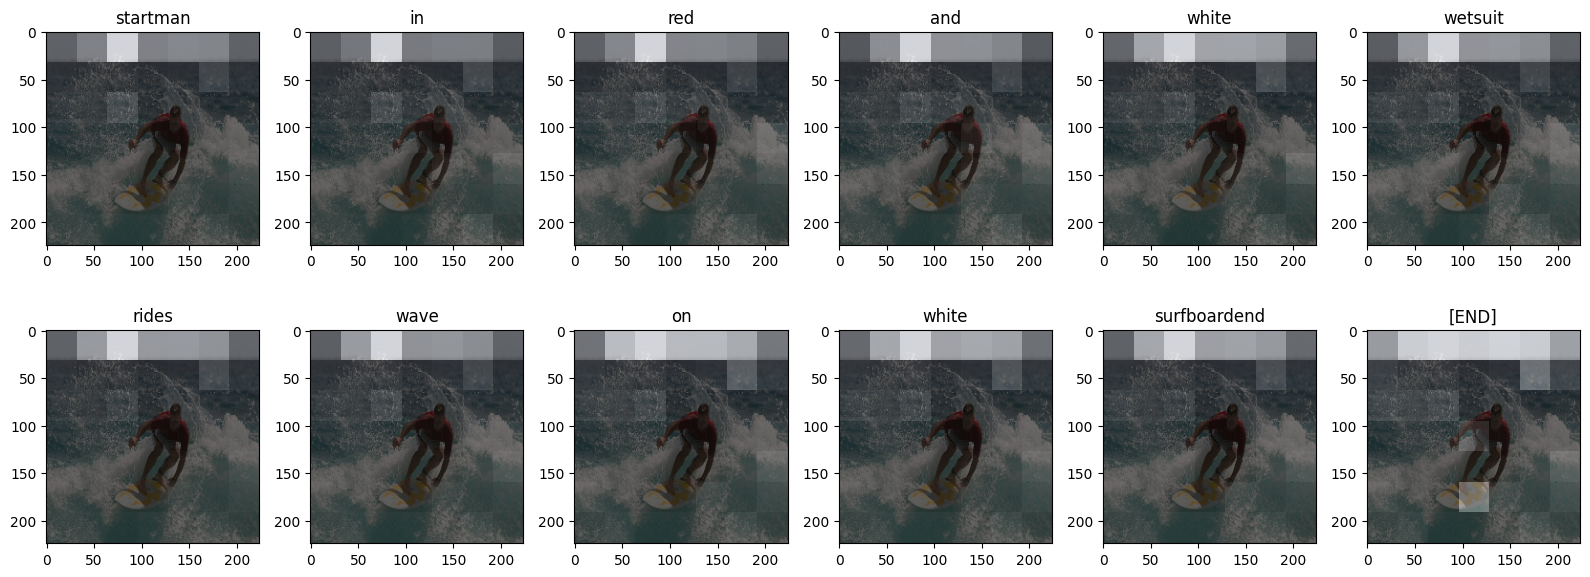

In [ ]:
plot_attention_maps(image/255, str_tokens, attention_maps)

Now put that together into a more usable function:

In [ ]:
@Captioner.add_method
def run_and_show_attention(self, image, temperature=0.0):
    result_txt = self.simple_gen(image, temperature)
    str_tokens = result_txt.split()

    # Remove "[START]" and "[END]" tokens if they are present
    str_tokens = [token for token in str_tokens if token.lower() not in ("[start]", "[end]")]

    # Remove "end" from the end of any token containing it
    str_tokens = [token[:-3] if token.lower().endswith("end") else token for token in str_tokens]

    # Extract relevant word from the first token (assuming "startman" or similar)
    first_token = str_tokens[0]
    if first_token.lower().startswith("start"):
        first_token = first_token[5:]  # Remove "start" prefix
    str_tokens[0] = first_token  # Replace the first token

    attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
    attention_maps = tf.concat(attention_maps, axis=0)
    attention_maps = einops.reduce(
        attention_maps,
        'batch heads sequence (height width) -> sequence height width',
        height=7, width=7,
        reduction='mean')

    plot_attention_maps(image/255, str_tokens, attention_maps)
    t = plt.suptitle(result_txt)
    t.set_y(1.05)

    return ' '.join(str_tokens)  # Return the predicted caption without "[START]", "[END]", and "end" from the end of tokens


In [ ]:
run_and_show_attention(model, image)

'man in red and black wetsuit riding in the ocean'

## Try it on your own images

For fun, below you're provided a method you can use to caption your own images with the model you've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for strange results!)


In [ ]:
def demo(url):


  image_url = url
  image_path = tf.keras.utils.get_file(origin=image_url)
  image = load_image(image_path)

  caption = run_and_show_attention(model, image)


  response = requests.get(image_url)
  image_data = BytesIO(response.content)
  imageshow = Image.open(image_data).convert('RGB')
  return caption, imageshow


In [ ]:
# caption, imageshow = demo("https://cdn.shopify.com/s/files/1/1600/7061/files/5_rescue_dogs.jpg?v=1681913350")


In [ ]:
# import gradio as gr
finalDemo = gr.Interface(fn = demo,inputs = "text", outputs = ["text", "image",])
finalDemo.launch()